We are some common modules used in machine learning for importing/modifying data as well as visualizing data.

In [1]:
#import pandas as pd
import numpy as np
import seaborn as sb
import dask.dataframe as dd
import modin.pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


We are using the pandas module to create a dataframe using the encoded_df_blanks_as_na.csv file for our features dataframe. features_df contains the independent variables used to train our machine learning model. These are the characterisitcs of the data that our model will analyze to make predictions.

In [2]:
'''
- A one-hot encoded matrix of features, with 11599 person names (nam_id_XXXX)
    and 4784 place names (geo_id_XXXX) as columns.
- The first column contains unique text_id corresponding to individual texts.
'''
features_df = pd.read_csv('encoded_df_blanks_as_na.csv')

2024-12-08 22:14:32,396	INFO worker.py:1821 -- Started a local Ray instance.


We are using the pandas module to create a dataframe using the 20240103_texts_with_dates.csv file for our labels dataframe. We then preview the dataframe. labels_df contains the dependent variables (target values) our model is trying to predict. These are the outputs corresponding to observations in the features_df. y1 and y1 willl serve as the ground truth our model learns to predict.

We later switched to the modin pandas module to leverage multithreading, as it took forever to run without it.

In [3]:
'''
- text_id: same as the text id in the features dataset
- y1: The earliest possible date the text was written.
- y2: The latest possible date the text was written.
- If y1 and y2 are equal, the date of writing is known with certainty.
'''

labels_df = pd.read_csv('20240103_texts_with_dates.csv')

labels_df

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


,tex_id,geotex_id,written,found,geo_id,language_text,material_text,y1,y2,remark,Unnamed: 10,Unnamed: 11
0,12042,8388,1,1,1008,Greek,papyrus,117,118,NaN,NaN,- y1 = earliest possible year of writing
1,12054,8391,1,1,1008,Greek,papyrus,119,119,NaN,NaN,- y2 = latest possible year of writing
2,12063,8393,1,1,1008,Greek,papyrus,96,98,NaN,NaN,"[if y1 = y2, then we are certain of the date]"
3,12064,8394,1,1,1008,Greek,papyrus,131,131,NaN,NaN,NaN
4,17239,9507,0,1,1008,Greek,papyrus,108,108,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
29245,967240,1021239,1,0,332,Greek,papyrus,-263,-229,NaN,NaN,NaN
29246,5910,5438,1,1,1344,Greek,papyrus,-148,-148,NaN,NaN,NaN
29247,3506,4066,1,1,1344,Demotic / Greek,papyrus,-150,-150,NaN,NaN,NaN
29248,7491,6778,0,1,720,Demotic / Greek,papyrus,-236,-236,new,NaN,NaN


**One Hot Encoding**

Looking at the features file, it is one-hot encoded. One-hot encoding is a method used to represent categorical data as binary values. It is commonly used to convert non-numerical data into a format that algorithms can process effectively as well as avoiding implicit ordinal relationships. It works by identifying all unique categories and creating binary columns for all of them. We assign 1 to the column corresponding to the presence of that data and 0 for all other related columns.

This file was not fully one-hot encoded at first. It had a 1 for all values, but a NULL for the absence of features. All NULL values should be filled with a 0 to represent the absence of that feature and clean the data more.

After filling all NaN columns, we preview the first 5 columns of the features_df. We are setting the text_id as the index of the features_df because although it is a column, it is not actually a feature but rather a unique identifier for each row.

Lastly, we print information about the shape of the dataframe.

In [4]:
# Printing information about the features dataset
features_df = features_df.fillna(0)

# gets 5 random rows, only first 10 columns
print(features_df.sample(5).iloc[:, :10])

features_df.set_index('text_id', inplace=True)



       text_id  nam_id_1057.0  nam_id_19683.0  nam_id_356.0  nam_id_904.0  \
29069   170048            0.0             0.0           0.0           0.0   
21831    50877            0.0             0.0           0.0           0.0   
29892   832085            0.0             0.0           1.0           0.0   
22718    55433            0.0             0.0           0.0           0.0   
7071     13090            0.0             0.0           0.0           0.0   

       nam_id_2227.0  nam_id_726.0  nam_id_761.0  nam_id_731.0  nam_id_1246.0  
29069            0.0           0.0           0.0           0.0            0.0  
21831            0.0           0.0           0.0           0.0            0.0  
29892            0.0           0.0           0.0           0.0            0.0  
22718            0.0           0.0           0.0           0.0            0.0  
7071             0.0           0.0           0.0           0.0            0.0  


Number of rows: 30324
Number of columns: 16383
Minimum y1: -1292.0
Maximum y2: 1099.0


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


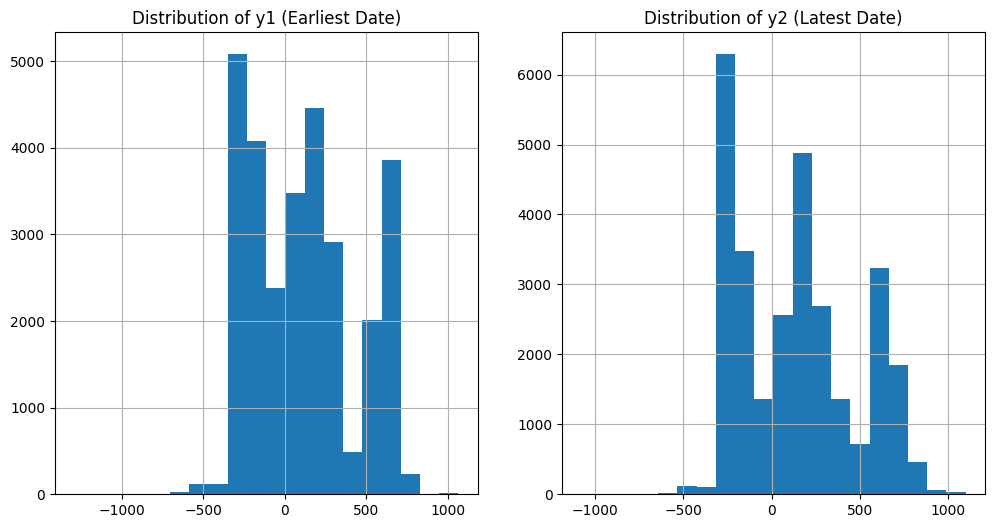

In [5]:

# Print the number of rows and columns
print(f'Number of rows: {features_df.shape[0]}')
print(f'Number of columns: {features_df.shape[1]}')

# Explore target labels (y1 and y2) distribution
print(f'Minimum y1: {labels_df["y1"].min()}')
print(f'Maximum y2: {labels_df["y2"].max()}')

# Distribution of y1 and y2 (histograms or value counts)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
labels_df['y1'].hist(bins=20)
plt.title('Distribution of y1 (Earliest Date)')
plt.subplot(1, 2, 2)
labels_df['y2'].hist(bins=20)
plt.title('Distribution of y2 (Latest Date)')
plt.show()

**Data Preprocessing**

Data preprocessing is the stage in machine learning where raw data is cleaned and prepared for analysis or model training. Firstly, we cleaned the data by filling NULLS with 0's for one-hot encoding. Now, we are removing duplicate rows from features_df and labels_df to ensure the dataset is clean, consistent, and free from redundancy. Duplicates can influence bias which would negatively impact the performance of our model.

<font color='red'>Remove outliers?</font>

In [6]:
# Check for any remaining missing values after filling NaNs
print(features_df.isnull().sum())

# Inspect the first few rows of both dataframes to verify alignment
print(features_df.head())
print(labels_df.head())


nam_id_1057.0     0
nam_id_19683.0    0
nam_id_356.0      0
nam_id_904.0      0
nam_id_2227.0     0
                 ..
nam_id_27140.0    0
nam_id_43504.0    0
nam_id_22369.0    0
nam_id_26361.0    0
geo_id_2078       0
Length: 16383, dtype: int64
         nam_id_1057.0  nam_id_19683.0  nam_id_356.0  nam_id_904.0  \
text_id                                                              
1                  1.0             1.0           1.0           1.0   
2                  0.0             0.0           1.0           1.0   
3                  0.0             0.0           1.0           0.0   
4                  0.0             0.0           1.0           0.0   
5                  0.0             0.0           1.0           0.0   

         nam_id_2227.0  nam_id_726.0  nam_id_761.0  nam_id_731.0  \
text_id                                                            
1                  1.0           1.0           1.0           1.0   
2                  0.0           0.0           1.0       

Check for the distribution of person and place features. 
This will help us understand how these features relate to the target labels.

In [7]:

# Explore distribution of features (first few person/place columns)
person_columns = [col for col in features_df.columns if col.startswith('nam_id')]
place_columns = [col for col in features_df.columns if col.startswith('geo_id')]

# Show summary statistics of the first few person and place features
print(features_df[person_columns[:5]].describe())
print(features_df[place_columns[:5]].describe())

       nam_id_1057.0  nam_id_19683.0  nam_id_356.0  nam_id_904.0  \
count   30324.000000    30324.000000  30324.000000  30324.000000   
mean        0.000857        0.000758      0.088643      0.016291   
std         0.029269        0.027530      0.284232      0.126593   
min         0.000000        0.000000      0.000000      0.000000   
25%         0.000000        0.000000      0.000000      0.000000   
50%         0.000000        0.000000      0.000000      0.000000   
75%         0.000000        0.000000      0.000000      0.000000   
max         1.000000        1.000000      1.000000      1.000000   

       nam_id_2227.0  
count   30324.000000  
mean        0.011377  
std         0.106057  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
        geo_id_1704   geo_id_1628    geo_id_100   geo_id_2982   geo_id_2023
count  30324.000000  30324.000000  30324.000000  30324.000000  30324.000000
mean       0.024139      0.0

In [8]:
# Create a new column to flag if the date is uncertain (y1 != y2)
labels_df['date_uncertain'] = labels_df['y1'] != labels_df['y2']

# Check the distribution of the uncertain dates
print(labels_df['date_uncertain'].value_counts())


date_uncertain
True     16698
False    12552
Name: count, dtype: int64


the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


In [9]:
# Check for duplicates in the labels dataframe
print(f"Number of rows before removing duplicates: {labels_df.shape[0]}")
print(f"Number of duplicate rows: {labels_df.duplicated().sum()}")

# Remove duplicate rows
labels_df = labels_df.drop_duplicates()

# Verify duplicates are removed
print(f"Number of rows after removing duplicates: {labels_df.shape[0]}")

Number of rows before removing duplicates: 29250
Number of duplicate rows: 0
Number of rows after removing duplicates: 29250


We are further preparing the data by removing features with low variance. Variance refers to how much the values in a feature vary. Features with very little variation don't provide value for prediction because there aren't enough differences in the data for the model to learn any patterns. By removing these low-variance features, we simplify the model, reduce overfitting, and improve computational efficiency.

The threshold we chose is arbitrary since it is a hyper parameter. We tuned our models by setting various thresholds and seeing which one resulted in the lowest MAE. A threshold of 0.001 produced our best result.

fit_transform calculates the variance of each feature in features_df and removes features whose variance is below our specified threshold.

Printing our original and reduced shape shows how we are able to reduce our dimensions by 15,038. There were diminishing returns with feature reduction. After a certain point, it was better to have more features. Originally, we reduced to 143 columns but 1345 performed better.

In [10]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-variance features
selector = VarianceThreshold(threshold=0.001)  # Adjust threshold as needed
features_reduced_df = selector.fit_transform(features_df)

print(f"Original shape: {features_df.shape}")
print(f"Reduced shape: {features_reduced_df.shape}")

Original shape: (30324, 16383)
Reduced shape: (30324, 1309)


We decided to use Singular Value Decomposition (SVD) for dimensionality reduction because it is good at reducing the number of features in high-dimensional datasets and sparse matrixes in particular. Our data was an extremely sparse matrix. SVD reduces the number of features while retaining the most important information. We chose 1000 principal components to keep because it performed well after testing various values for this hyperparameter. The explained variance ratio shows that even after reducing our features by over 15000, we still manage to capture 95% of the variance in 1000 components.

<font color='red'>EXPLAIN SVD MORE</font>

**WHY SVD INSTEAD OF PCA?**

We chose SVD over PCA for several reasons such as nonlinear relationships, sparse matrixes, and large datasets. SVD is more flexible in handling non-linear relationships and can be used as a general-purpose dimensionality reduction technique. We were able to determine our data was non-linear by comparing the results of models based on linear and nonlinear approaches. Our nonlinear models outperformed our linear models by far. SVD is also useful when dealing with sparse data, which is the case for our data. SVD seemed like a better option due to the size of our dataset as well. PCA involves calculating a covariance matrix which would take longer than SVD to process.

When trying n_components significantly over 1000, often variance retention would be >0.9999, which led to worse model results due to overfitting.

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
# svd = TruncatedSVD(n_components=2000, random_state=42)
features_svd = svd.fit_transform(features_reduced_df)

print(f"Original shape: {features_reduced_df.shape}")
print(f"Reduced shape: {features_svd.shape}")

#print(svd.explained_variance_ratio_)
print(sum(svd.explained_variance_ratio_))  # Total variance retained

Original shape: (30324, 1309)
Reduced shape: (30324, 1000)
0.9577358354531391


The following cell converts our features_svd array back into a dataframe features_svd_df.

In [12]:
# Assuming reduced_features is your NumPy array from SVD or Variance Thresholding
# features_df['text_id'] contains the IDs you need to reattach
features_df.reset_index(inplace=True)
features_svd_df = pd.DataFrame(features_svd, columns=[f'feature_{i}' for i in range(features_svd.shape[1])])
features_svd_df['text_id'] = features_df['text_id'].values


This is one of the most important cells because it prepares our training set. Our original label and features files have around 20k and 30k rows respectively. Not every row of data in the features dataset has a corresponding row of data in the labels dataset and vice versa. In order to train our model, we need to give it data that it already knows the answers for - the ground truths. This is the metric we will compare our predictions against to guage the performance of our models. Although we cleaned our data for duplicates before, we wanted to ensure the data was thoroughly prepared as we inch closer to training our model.

After removing duplicates and data that didn't appear in both the label and features datasets, we were left with 8565 datapoints with corresponding labels. This is the data we use to train our model.

In [13]:
# Get text_ids in each dataset
features_text_ids = set(features_svd_df['text_id'])
labels_text_ids = set(labels_df['tex_id'])

# Find unmatched text_ids
missing_in_labels = features_text_ids - labels_text_ids
missing_in_features = labels_text_ids - features_text_ids

print(f"Text IDs missing in labels: {len(missing_in_labels)}")
print(f"Text IDs missing in features: {len(missing_in_features)}")

# Keep only common text_ids
common_text_ids = features_text_ids & labels_text_ids

# Filter features and labels datasets
features_common_df = features_svd_df[features_svd_df['text_id'].isin(common_text_ids)]
labels_common_df = labels_df[labels_df['tex_id'].isin(common_text_ids)]

# Check the updated shapes
print(f"Updated features shape: {features_common_df.shape}")
print(f"Updated labels shape: {labels_common_df.shape}")

# Check for duplicated rows
duplicate_rows = features_common_df.duplicated()

# Check for duplicated text_ids
duplicate_text_ids = features_common_df['text_id'].duplicated()

print(f"Total duplicate rows: {duplicate_rows.sum()}")
print(f"Total duplicate text_ids: {duplicate_text_ids.sum()}")

# Check for duplicate rows
duplicate_label_rows = labels_common_df.duplicated()

# Check for duplicate text_ids
duplicate_label_text_ids = labels_common_df['tex_id'].duplicated()

print(f"Total duplicate rows: {duplicate_label_rows.sum()}")
print(f"Total duplicate text_ids: {duplicate_label_text_ids.sum()}")

# Drop duplicate text_ids, keeping the first occurrence
features = features_common_df.drop_duplicates(subset='text_id', keep='first')

# Drop duplicate text_ids, keeping the first occurrence
labels = labels_common_df.drop_duplicates(subset='tex_id', keep='first')


# Ensure alignment of text_ids between features and labels
common_text_ids = set(features['text_id']) & set(labels['tex_id'])

# Filter again if necessary
features_filtered_df = features[features['text_id'].isin(common_text_ids)]
labels_filtered_df = labels[labels['tex_id'].isin(common_text_ids)]

print(f"Aligned features shape: {features_filtered_df.shape}")
print(f"Aligned labels shape: {labels_filtered_df.shape}")


Text IDs missing in labels: 21216
Text IDs missing in features: 11838
Updated features shape: (9108, 1001)
Updated labels shape: (13680, 13)
Total duplicate rows: 0
Total duplicate text_ids: 0
Total duplicate rows: 0
Total duplicate text_ids: 4572
Aligned features shape: (9108, 1001)
Aligned labels shape: (9108, 13)


We set the index of our dataframes to the text_ids since are not considered features, but rather unique identifiers of each datapoint.

In [14]:
features_filtered_df.set_index('text_id', inplace=True)

labels_filtered_df.rename(columns={'tex_id': 'text_id'}, inplace=True)
labels_filtered_df.set_index('text_id', inplace=True)

Since our task involves predicting the year a text was written, retaining the other ground truth labels was unnecessary. Removing them avoids confusion and ensures our process is focused solely on the data relevant to our task.

<font color="red"> Should we convert the other labels into features before dimension reduction?</font>

In [15]:
labels_final_df = labels_filtered_df[['y1','y2']]
labels_final_df

,y1,y2
text_id,,
12042,117,118
12054,119,119
12063,96,98
12064,131,131
17239,108,108
...,...,...
703104,-250,-175
703317,-263,-229
5910,-148,-148


Although this step is redundant, we wanted to ensure all of our datapoints were merged with a corresponding label via an inner join. This could be skipped altogether since we are separating the y label from the X features when training our model, but having it as one dataframe in the beginning aligned with our approaches throughout the course.

<font color="red">Can we replace the cell above where we filter for records in both features_df and labels_df by only using this method?</font>

In [16]:
# Merge on text_id
merged_df = features_filtered_df.merge(labels_final_df, on='text_id', how='inner')

merged_df.shape

(9108, 1002)

<h1>Classification or Regression?</h1>

Here we are creating two variables that indicate how many rows exist where y1=y2 and y1!=y2 and displaying those results.

Since we have more rows where an exact year is known (5,239) we believe regression was the better approach because predicting an exact year (a continuous variable) aligns with the strengths of regression.

If we had more cases where y1!=y2, then there would be more uncertainty about the exact date of our texts, justifying the use of a classifcation model where we simplify the task by binning the ranges into predifined categories (100-199AD, 200-299AD).

Based on the context of our training data, we believed regression was the better approach because the majority of our ground truths were a single continous year vs a range of years.

<b>We chose Regression</b>

<font color="red"> Should we create classification models anyway for comparison?</font>

<font color="red">Should we combine classifcation and regression models into one model?
ex. classifcation followed by regression
ex. regression followed by classification
ex. multi-output neural network</font>

In [17]:
equal_rows = merged_df[merged_df['y1'] == merged_df['y2']].shape[0]
unequal_rows = merged_df[merged_df['y1'] != merged_df['y2']].shape[0]

print(f"Number of rows where y1 = y2: {equal_rows}")
print(f"Number of rows where y1 != y2: {unequal_rows}")

Number of rows where y1 = y2: 5568
Number of rows where y1 != y2: 3540


Since we chose regression, we created a target column that handles both cases when y1 equals y2 (continuous) and when y1 didn't equal y2 (range of years).

y_target simply became y1 if they were equal
y_target took the midpoint of y1 and y2 if they weren't equal. The midpoint serves as a reasonable estimate for a range when an exact year isn't available.

In [18]:
merged_df['y_target'] = merged_df.apply(
    lambda row: row['y1'] if row['y1'] == row['y2'] else (row['y1'] + row['y2']) / 2,
    axis=1
)
# Now, let's add 'date_uncertain' as a feature
merged_df['date_uncertain'] = merged_df['y1'] != merged_df['y2']

# Check the updated dataframe
print(merged_df.head())

         feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
text_id                                                                     
1         0.407687  -0.339652   0.577915   0.236062   0.111234  -0.021248   
2         1.197963  -0.464093   0.788213  -0.108202   0.918461   0.902399   
3         0.671469  -0.424639   0.356897  -0.003133   0.223691   0.077651   
4         1.230311  -0.612838   0.707190  -0.165581   0.932456   0.654450   
5         0.405977  -0.311168   0.482294   0.171589   0.129961  -0.034979   

         feature_6  feature_7  feature_8  feature_9  ...  feature_994  \
text_id                                              ...                
1        -0.153746  -0.007755   0.013452   0.273916  ...    -0.068806   
2        -0.405444  -0.100074  -0.975100  -0.009527  ...     0.008823   
3         0.235716  -0.357372   0.663473   0.342369  ...     0.023752   
4        -0.259247   0.097634  -0.439642  -0.248355  ...    -0.023407   
5        -0.137464   0

After creating our new ground truth y_target, we no longer needed the labels y1 and y2.

In [19]:
merged_df = merged_df.drop(columns=['y1','y2'])
merged_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,y_target,date_uncertain
text_id,,,,,,,,,,,,,,,,,,,,,
1,0.407687,-0.339652,0.577915,0.236062,0.111234,-0.021248,-0.153746,-0.007755,0.013452,0.273916,...,-0.025979,-0.026186,-0.068806,0.026521,-0.027352,-0.014985,0.023677,-0.052546,-124.0,False
2,1.197963,-0.464093,0.788213,-0.108202,0.918461,0.902399,-0.405444,-0.100074,-0.975100,-0.009527,...,0.031256,0.036513,0.008823,-0.017260,0.007761,-0.025403,0.028005,0.018981,-112.0,False
3,0.671469,-0.424639,0.356897,-0.003133,0.223691,0.077651,0.235716,-0.357372,0.663473,0.342369,...,0.039853,-0.027543,0.023752,-0.041222,0.011726,0.030228,0.019802,-0.023849,-109.0,False
4,1.230311,-0.612838,0.707190,-0.165581,0.932456,0.654450,-0.259247,0.097634,-0.439642,-0.248355,...,-0.003633,0.136953,-0.023407,0.094549,0.000708,0.061064,-0.040254,0.001183,-108.0,False
5,0.405977,-0.311168,0.482294,0.171589,0.129961,-0.034979,-0.137464,0.036390,-0.024269,0.261850,...,0.011111,0.000981,0.004935,-0.012496,-0.007738,-0.005672,0.009419,0.006109,-106.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981643,0.008969,0.016180,0.017711,0.009963,-0.044117,0.042820,-0.021977,-0.004083,0.015843,0.004510,...,0.001501,-0.002782,-0.000141,0.000533,-0.003005,-0.001328,-0.002025,0.005040,548.0,False
981644,0.222674,0.387596,0.175491,-0.096563,-0.086935,0.119067,-0.463115,0.014110,0.505928,-0.109398,...,-0.000283,0.000014,-0.000176,-0.004651,-0.004013,-0.000948,0.002560,0.004841,553.0,False
981646,0.019605,0.036823,0.038894,0.021325,-0.082492,0.075968,-0.025609,0.000499,0.022658,0.009609,...,0.001046,0.001083,0.000363,-0.000543,0.003878,0.002361,-0.003265,-0.001137,549.0,False


<h1>TRAINING & COMPARING OUR MODELS</h1>

This code splits our dataset into training and testing subsets to prepare it for our machine learning algorithms.

X contains all of our features
y contains our label

We are then splitting the data into training and testing subsets, using 20% of the data for testing and 80% for training. We set random_sate =42 for reproducibility.

The purpose of splitting our data is to evaluate how well the model generalizes to unseen data. Our training sets are used to train the model while the testing set is used afterward to assess the model's performance on data it hasn't seen during training.

We did not scale our data because the original data was one-hot encoded and reducced using Variance Thresholding and SVD. Variance Thresholding only removes features with low variance and doesn't change their scales. SVD produces principle components that are linear combinations of our original features, but SVD already scales them to optimize variance. The components were normalized internally in the decomposition process of the SVD class.

In [22]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = merged_df.drop(columns=['y_target'])
y = merged_df['y_target']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

# Convert all boolean columns in the dataset to integers
X_train = X_train.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X_test = X_test.applymap(lambda x: int(x) if isinstance(x, bool) else x)


(7286, 1001)
(1822, 1001)


<h1>LINEAR OR NONLINEAR RELATIONSHIPS?</h1>
After training all of our models, it is apparent our the relationships in our data may be nonlinear.

Our Lasso and Ridge Regression lienar models performed significantly worse. These models assume that the relationship between the features and target is linear.

Our RandomForest and XGBoost ensemble nonlinear models performed far better. These models capture nonlinear relationships in the data. They work by splitting the features into smaller tress and makes decisions based on those trees.

<h1>LASSO</h1>

We are using Lasso  linear regression model with cross validation, using 5 folds. Lasso adds an L1 regularization term to the update function. Lasso is able to shrink some coefficients to 0, basically reducing some of our features. Lasso was our poorest performing model.

In [23]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error

# Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Evaluate performance
print("Lasso - Best alpha:", lasso.alpha_)
print("Train MAE:", mean_absolute_error(y_train, lasso.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, lasso.predict(X_test)))

lasso_features = pd.Series(lasso.coef_, index=X.columns)
print("Selected features by Lasso:")
print(lasso_features[lasso_features != 0])



Lasso - Best alpha: 0.10065848829644768
Train MAE: 110.6250906749479
Test MAE: 118.26166652971969
Selected features by Lasso:
feature_0          29.586222
feature_1         284.814829
feature_2          29.551639
feature_3          60.023492
feature_4        -249.803620
                     ...    
feature_994        29.915784
feature_995       -57.844014
feature_997       -64.634300
feature_998         5.194057
date_uncertain     51.666133
Length: 562, dtype: float64


<h1>RIDGE</h1>

The code below performs ridge regression with cross-validation. Ridge regression adds an L2 regularization to the linear regression model, which penalizes large coefficient values and helps prevent overfitting. The strength of the regularization is controlled by the alpha parameter when instantiating the RidgeCV class. We are also performing 5-fold cross validation, which means it splits the training data into 5 parts, trains the model of 4 parts and validates on the remaing part, and repeats this process 5 times as it iterates through each fold.

The mean absolute error, MAE, measures the average absolute difference between our predicted values and the ground truths. The lower the MAE, the better. After printing the MAE of our best Ridge model's best parameters, we had a Train and TEST MAE of 109.62 and 124.12. These are some of our lowest scores after comparing all of our models. The poor results on Ridge and Lasso compared to our other models suggests that our data is nonlinear.

In [24]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error

# Ridge with cross-validation
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge.fit(X_train, y_train)

# Evaluate performance
print("Ridge - Best alpha:", ridge.alpha_)
print("Train MAE:", mean_absolute_error(y_train, ridge.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, ridge.predict(X_test)))

ridge_features = pd.Series(ridge.coef_, index=X.columns)
print("Ridge coefficients:")
print(ridge_features.sort_values(ascending=False).head(10))  # Top 10



Ridge - Best alpha: 10.0
Train MAE: 107.4174776997243
Test MAE: 116.69859835174945
Ridge coefficients:
feature_1      283.340679
feature_117    136.619684
feature_668    120.557338
feature_22     116.249011
feature_461    114.521665
feature_72     111.953832
feature_434    111.309247
feature_34     109.667555
feature_707    104.077337
feature_462    101.998901
dtype: float64


<h1>RANDOM FOREST</h1>

This code implements a RandomForest model designed for regression tasks. It builds 100 decision tress in the "forest" (model).

A random forest is an ensemble learning algorithm that combines multiple decision tress to improve prediction accuracy and reduce overfitting. The algorithm does something called bootstrap sampling, which randomly selects samples with replacement from the training data to create several datasets for training the individual trees we specified in the parameter. For each decision tree, the algorithm selects a random subset of features at each split. Each tree in the forest predicts a value and the final prediction is the average of all tree predictions in the forest. Random Forest is effective at solving tasks because it uses many tress instead of a single deicision tree to make an accurate prediction. This ensemble reduces variance in the predictions. It also handles complex, nonlinear relationships in the data which seems to be the case in our dataset.

After 8m 15s of execution, our initial RandomForest produced results far better than our Linear and Ridge models, having a training MAE of 30.7 and test MAE of 78.6.

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, 
                                random_state=42, 
                                #Tried playing with these parameters. They get faster results, and less overfitting, but the Test MAE is worse so i've left them commented out.
                                #max_depth=10, 
                                #min_samples_split=10, 
                                #min_samples_leaf=5,  
                                #max_features='sqrt', 
                                n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate performance
print("Random Forest - Train MAE:", mean_absolute_error(y_train, rf_model.predict(X_train)))
print("Random Forest - Test MAE:", mean_absolute_error(y_test, rf_model.predict(X_test)))

Random Forest - Train MAE: 29.255435168695872
Random Forest - Test MAE: 76.32743520557159


<h1>OPTIMIZING RANDOM FOREST</h1>

The RandomForest regressor was one of our highest performing models. It performed far better than Lasso and Ridge, so we wanted to improve the model by searching for better hyper parameters.

We decided to use GridSearch cross validation with performs a systematic search over a range of hyperparameter combinations we assign for our RandomForestRegressor model. We are passing in parameters to control the amount of trees in the forest, the maximum depth of each tree, and the minimum number of samples required to split a node in each tree. We are also using 5 fold cross validation.

After execution, we found our best parameters were:

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

Best Random Forest Test MAE: 92.32550495382549



In [26]:
import pandas as pd
# RandomizedSearchCV doesn't like modin. convert to pandas 
X_train2 = X_train._to_pandas()
y_train2 = y_train._to_pandas()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


## BEWARE!! RUNNING THIS CELL TAKES 3 HOURS TO EXECUTE.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_distributions=param_grid, n_iter=5, cv=3, n_jobs=-1, verbose=3)
randomized_search.fit(X_train2, y_train2)

print("Best Parameters:", randomized_search.best_params_)
print("Best Random Forest Test MAE:", mean_absolute_error(y_test, randomized_search.best_estimator_.predict(X_test)))


After finding our best hyper parameters, we reran the RandomForestRegressor with the new hyper parameters to see our results. Expectedly, they improved. However, we wanted to explore other models to see if there was even better performance.

In [27]:
# Train Random Forest
rf_model = RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate performance
print("Random Forest - Train MAE:", mean_absolute_error(y_train, rf_model.predict(X_train)))
print("Random Forest - Test MAE:", mean_absolute_error(y_test, rf_model.predict(X_test)))

Random Forest - Train MAE: 30.241163323492135
Random Forest - Test MAE: 76.13762129806976


<h1>XGBOOST (EXTREME GRADIENT BOOSTING)</h1>

This model is a gradient boosting ensemble learning algorithm. XGBoost is an efficient and accurate gradient boosintg framework for machine learning. We experimented with a bunch of different parameters manually, slowly improving our model from 81 MAE down to 71 MAE.

Boosting is an ensemble learning technique that combines weak learners (like shallow decision trees) sequentially to form a strong learner. Each new tree is trained to correct errors made by the previous shallow trees. Gradient boosting minimizes the update function by computing gradients of the loss with respect to the model's predictions. The XGBoost frameowkr in particular has regularization to prevent overfitting, is optimized for speed and low memory usage, and supports sparse data.

Only taking 20 seconds to run, our XGBoost model was our most successful and most efficient compared to the 18 minutes it took our RandomForest model. We were able to adjust our model to achieve an MAE of 71.2

In [28]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Initialize XGBRegressor with multithreading enabled
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.031,
                        max_depth=7, alpha=25, n_estimators=350, n_jobs=-1)  # -1 enables multithreading

# Train the model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE: {mae}")


XGBoost MAE: 68.14354441022965


The R^2 value for our XGBoost model was 0.84 which indicates that 84% of the variation in our target variable was captured by the model. This indicates that the features we reduced to are highly predictive of the target variable.

In [29]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE and R-squared
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost MAE: {mae}")
print(f"XGBoost R-squared: {r2}")


XGBoost MAE: 68.14354441022965
XGBoost R-squared: 0.8378113155872244


In [32]:
# Split data into features (X) and target (y)
X = merged_df.drop(columns=['y_target'])  # Replace with your feature dataframe
y = merged_df['y_target']  # Replace with your target column

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure X_train and X_test are numeric
X_train = X_train.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X_test = X_test.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [33]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# Initialize LightGBM Regressor
lgb_reg = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=42,
    learning_rate=0.04,
    n_estimators=600,
    max_depth=-1,  # No max depth
    random_state=42,
    n_jobs=-1
)

# Train the model
lgb_reg.fit(X_train, y_train)

# Predict on test data
y_pred_lgb = lgb_reg.predict(X_test)

# Evaluate performance
lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
print(f"LightGBM MAE: {lgb_mae}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255002
[LightGBM] [Info] Number of data points in the train set: 7286, number of used features: 1001
[LightGBM] [Info] Start training from score 122.996432
LightGBM MAE: 69.37708908152341


In [34]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# Create a pipeline to scale the data and apply SVR
svm_pipeline = make_pipeline(
    StandardScaler(),  # SVM benefits from scaling the data
    SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Radial Basis Function kernel
)

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluate performance
svm_mae = mean_absolute_error(y_test, y_pred_svm)
print(f"SVM MAE: {svm_mae}")


SVM MAE: 213.8609622578169


In [35]:
xg_reg.get_booster().get_score(importance_type='gain')

{'feature_0': 69632.53125,
 'feature_1': 3289212.5,
 'feature_2': 1288795.75,
 'feature_3': 547318.6875,
 'feature_4': 2206215.5,
 'feature_5': 1091845.0,
 'feature_6': 317597.46875,
 'feature_7': 343053.875,
 'feature_8': 437787.6875,
 'feature_9': 139245.953125,
 'feature_10': 289614.78125,
 'feature_11': 311026.84375,
 'feature_12': 239431.90625,
 'feature_13': 819283.75,
 'feature_14': 353530.75,
 'feature_15': 189499.46875,
 'feature_16': 447874.71875,
 'feature_17': 377258.65625,
 'feature_18': 588562.6875,
 'feature_19': 306610.40625,
 'feature_20': 272373.1875,
 'feature_21': 257294.578125,
 'feature_22': 391639.96875,
 'feature_23': 315452.34375,
 'feature_24': 149635.765625,
 'feature_25': 176951.890625,
 'feature_26': 166799.5625,
 'feature_27': 254595.171875,
 'feature_28': 110564.7734375,
 'feature_29': 105759.5625,
 'feature_30': 88589.6484375,
 'feature_31': 444716.34375,
 'feature_32': 207692.21875,
 'feature_33': 158807.0625,
 'feature_34': 308824.09375,
 'feature_35':

### Tensorflow Imports

In [36]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.models import load_model
from keras.layers import Input, Add
from keras.models import Model
import matplotlib.pyplot as plt

### Tensorflow doesn't like the modin datasets, so we convert them to pandas here.

In [37]:
# Convert to NumPy array if it's a pandas DataFrame
X_train2 = X_train.to_numpy()
X_test2 = X_test.to_numpy()
y_train2 = y_train.to_numpy()
y_test2 = y_test.to_numpy()

# Create scalers
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()  # Using MinMaxScaler for target to bound values

# Scale features (X)
X_train_scaled = scaler_X.fit_transform(X_train2)
X_test_scaled = scaler_X.transform(X_test2)

# Scale target to [0, 1] range (y)
y_train_scaled = scaler_y.fit_transform(y_train2.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test2.reshape(-1, 1)).flatten()

# Print the shapes to verify
print("Scaled feature shapes:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

print("Scaled target shapes:")
print("y_train_scaled shape:", y_train_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

Scaled feature shapes:
X_train_scaled shape: (7286, 1001)
X_test_scaled shape: (1822, 1001)
Scaled target shapes:
y_train_scaled shape: (7286,)
y_test_scaled shape: (1822,)


### Model Builder

In [38]:
def create_model(input_dim, learning_rate=1e-4):
    input_layer = Input(shape=(input_dim,))  # The input dimension will now include the new feature
    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.35)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.35)(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    
    output = tf.keras.layers.Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output)
    
    loss_functions = [
        tf.keras.losses.MeanSquaredError(),
        tf.keras.losses.MeanAbsoluteError(),
        tf.keras.losses.Huber(delta=0.5)  # Adjust delta
        ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            clipvalue=1.0  # Added clip value
        ),
        loss=loss_functions,
        metrics=['mae']
    )
    
    return model


In [52]:
def train(model_file_name, epochs=250, learning_rate=1e-4, batch_size=32):
    # Create and train the model
    #model = load_model(file_name)# create_model(X_train_scaled.shape[1])
    if model_file_name is not None and os.path.exists(model_file_name):
        #import the model
        model = load_model(model_file_name) # type: ignore
    else:
        # Create the model
        model = create_model(X_train_scaled.shape[1], learning_rate)


    # Early stopping and learning rate reduction
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=60, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.75, 
            patience=10, 
            min_lr=1e-10
        ),
        tf.keras.callbacks.ModelCheckpoint(model_file_name, save_best_only=True)
    ]

    # Fit the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    model.save(model_file_name)
    
    return model, history
    

In [51]:
def evaluate_model(model, history):
    # Predict and inverse transform to get original scale
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Evaluate on original scale
    mae = np.mean(np.abs(y_pred.flatten() - y_test2))
    print(f"Mean Absolute Error: {mae}")

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/500
12/12 [==============================] - 2s 64ms/step - loss: 1.3581 - mae: 0.8286 - val_loss: 1.2046 - val_mae: 0.7968 - lr: 0.0100
Epoch 2/500
12/12 [==============================] - 0s 30ms/step - loss: 0.3419 - mae: 0.3599 - val_loss: 2.8935 - val_mae: 1.3183 - lr: 0.0100
Epoch 3/500
12/12 [==============================] - 0s 34ms/step - loss: 0.1738 - mae: 0.2537 - val_loss: 1.0066 - val_mae: 0.7661 - lr: 0.0100
Epoch 4/500
12/12 [==============================] - 0s 37ms/step - loss: 0.1076 - mae: 0.1907 - val_loss: 0.7001 - val_mae: 0.6081 - lr: 0.0100
Epoch 5/500
12/12 [==============================] - 0s 34ms/step - loss: 0.0961 - mae: 0.1729 - val_loss: 0.0876 - val_mae: 0.1606 - lr: 0.0100
Epoch 6/500
12/12 [==============================] - 0s 35ms/step - loss: 0.0871 - mae: 0.1597 - val_loss: 0.0798 - val_mae: 0.1464 - lr: 0.0100
Epoch 7/500
12/12 [==============================] - 0s 34ms/step - loss: 0.0835 - mae: 0.1542 - val_loss: 0.0778 - val_mae: 0.141

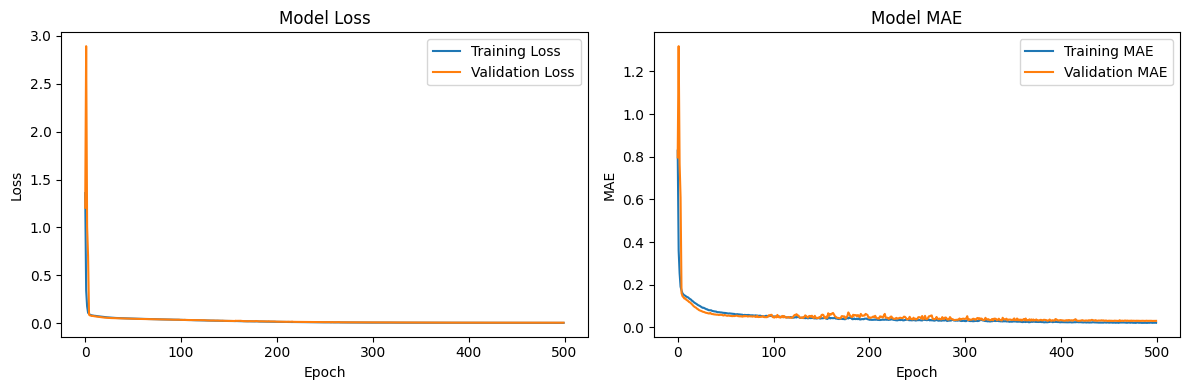

In [55]:
file_name="models/date_predictor-v27.h5"
model, history = train(file_name, epochs=500, learning_rate=1e-2, batch_size=512)
evaluate_model(model, history)

Epoch 1/500
92/92 [==============================] - 3s 21ms/step - loss: 0.0040 - mae: 0.0391 - val_loss: 0.0047 - val_mae: 0.0373 - lr: 1.3363e-04
Epoch 2/500
92/92 [==============================] - 2s 22ms/step - loss: 0.0039 - mae: 0.0386 - val_loss: 0.0047 - val_mae: 0.0368 - lr: 1.3363e-04
Epoch 3/500
92/92 [==============================] - 2s 22ms/step - loss: 0.0039 - mae: 0.0391 - val_loss: 0.0048 - val_mae: 0.0373 - lr: 1.3363e-04
Epoch 4/500
92/92 [==============================] - 2s 23ms/step - loss: 0.0041 - mae: 0.0401 - val_loss: 0.0048 - val_mae: 0.0376 - lr: 1.3363e-04
Epoch 5/500
92/92 [==============================] - 2s 22ms/step - loss: 0.0039 - mae: 0.0380 - val_loss: 0.0048 - val_mae: 0.0377 - lr: 1.3363e-04
Epoch 6/500
92/92 [==============================] - 2s 22ms/step - loss: 0.0038 - mae: 0.0386 - val_loss: 0.0047 - val_mae: 0.0361 - lr: 1.3363e-04
Epoch 7/500
92/92 [==============================] - 2s 21ms/step - loss: 0.0038 - mae: 0.0384 - val_loss:

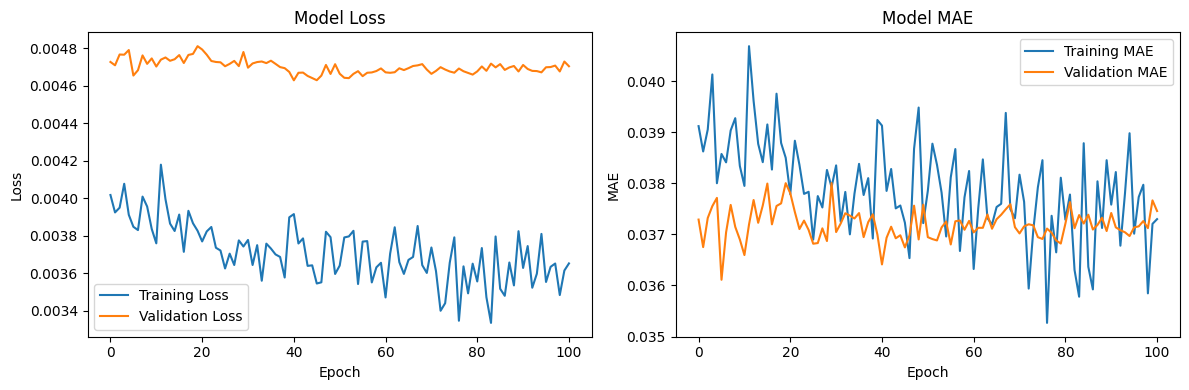

In [ ]:
file_name="models/date_predictor-v30.h5"
model, history = train(file_name, epochs=500, learning_rate=1e-2, batch_size=16)
evaluate_model(model, history)


--- Training Fold 1/5 ---
Epoch 1/250
183/183 [==============================] - ETA: 0s - loss: 3.6131 - mae: 1.4562
Epoch 1: val_loss improved from inf to 0.33184, saving model to models\date_predictor-v25_fold1.h5
183/183 [==============================] - 5s 20ms/step - loss: 3.6131 - mae: 1.4562 - val_loss: 0.3318 - val_mae: 0.3690 - lr: 1.0000e-04
Epoch 2/250
182/183 [============================>.] - ETA: 0s - loss: 2.8091 - mae: 1.2837
Epoch 2: val_loss improved from 0.33184 to 0.26230, saving model to models\date_predictor-v25_fold1.h5
183/183 [==============================] - 4s 21ms/step - loss: 2.8083 - mae: 1.2837 - val_loss: 0.2623 - val_mae: 0.3176 - lr: 1.0000e-04
Epoch 3/250
182/183 [============================>.] - ETA: 0s - loss: 2.3537 - mae: 1.1585
Epoch 3: val_loss improved from 0.26230 to 0.22105, saving model to models\date_predictor-v25_fold1.h5
183/183 [==============================] - 4s 21ms/step - loss: 2.3563 - mae: 1.1592 - val_loss: 0.2210 - val_mae:

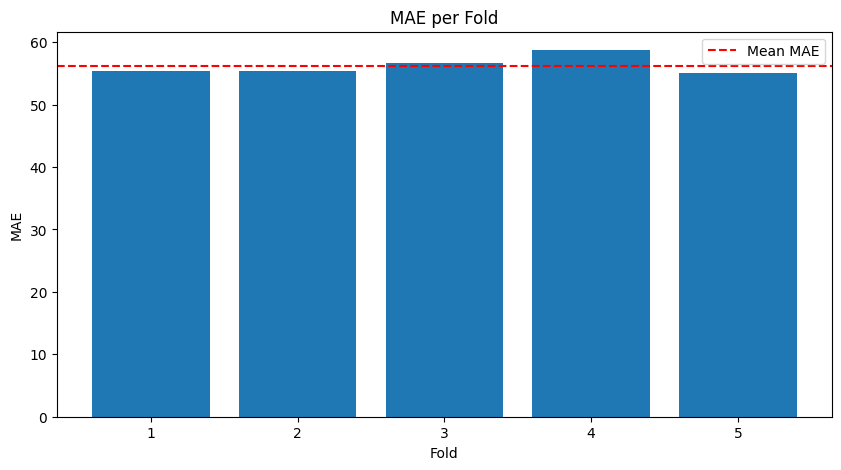

In [46]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import os

# Define K-Fold Cross-Validation Parameters
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Placeholder for fold performance metrics
fold_mae_scores = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_train2)):  # Replace with your full dataset variables
    print(f"\n--- Training Fold {fold + 1}/{k} ---")
    
    # Splitting data for this fold
    X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
    y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]
    
    # Create scalers
    scaler_X = StandardScaler()
    scaler_y = MinMaxScaler()
    
    # Scale features (X)
    X_train_scaled = scaler_X.fit_transform(X_train_fold)
    X_val_scaled = scaler_X.transform(X_val_fold)
    
    # Scale target to [0, 1] range (y)
    y_train_scaled = scaler_y.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val_fold.reshape(-1, 1)).flatten()

    # Define the model
    model = create_model(input_dim=X_train_scaled.shape[1], learning_rate=1e-4)

    # Define callbacks
    fold_model_file = f"{os.path.splitext(file_name)[0]}_fold{fold + 1}{os.path.splitext(file_name)[1]}"
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=30,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=6, 
            min_lr=1e-8
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=fold_model_file,
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=250,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model on the validation set
    y_val_pred_scaled = model.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    y_val_actual = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

    # Calculate MAE for this fold
    mae_score = np.mean(np.abs(y_val_pred.flatten() - y_val_actual))
    fold_mae_scores.append(mae_score)
    print(f"Fold {fold + 1} MAE: {mae_score}")

# Summarize Cross-Validation Results
print("\nCross-Validation Results:")
print(f"Average MAE: {np.mean(fold_mae_scores)}")
print(f"Standard Deviation of MAE: {np.std(fold_mae_scores)}")

# Visualization (optional)
plt.figure(figsize=(10, 5))
plt.bar(range(1, k+1), fold_mae_scores)
plt.axhline(np.mean(fold_mae_scores), color='r', linestyle='--', label='Mean MAE')
plt.title('MAE per Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()
plt.show()
